# https://www.kaggle.com/c/petfinder-adoption-prediction/data
## Phase 1 Objectives:
### Exploratory analysis, data cleaning, feature engineering
### Create binary classification models to determine if a pet will be adopted or not
### Calculate some accuracy statistics, ROC, etc
### Interpret impact of different input variables (if applicable to model selected)

## Phase 2 Objectives:
### implement NLP for description field
### predict adoption speed instead of just yes/no (survival?)



#### Import libraries and Read in data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.figure(figsize=(25,10))
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

train = pd.read_csv('train.csv')

train.head()

C:\Users\molly\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


<Figure size 1800x720 with 0 Axes>

#### check out data, clean up

In [2]:
train.dtypes

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object

In [3]:
train = train.drop(['RescuerID', 'State', 'Description', 'Breed1', 'Breed2', 'PetID', 'Color2', 'Color3'],axis = 1)

#bring back in description for phase 2, for now don't need
#breed is probably important.. but will be complicated with so many levels, so leaving out for now. bring back though!


#IDEAS FOR LATER:
#purebreds only have one breed listed, mutts have multiple. make a new variable for purebred vs mutt? ONLY FOR DOGS
#the name itself is probably worthless, but could make variable if pet has been named or not. lots of no-names in data.

In [4]:
#only want records for a single pet adoption, once filtered don't need Quantity
train = train[train.Quantity == 1]

train = train.drop(['Quantity'],axis = 1)

In [5]:
#changing adoption speed (0,1,2,3,4) to just a binary yes or no
#for phase 2 will use adpotion speed

train['Adopted'] = np.where(train['AdoptionSpeed']==4, 0, 1)
train = train.drop(['AdoptionSpeed'],axis = 1)
train.head()

,Type,Name,Age,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,VideoAmt,PhotoAmt,Adopted
0,2,Nibble,3,1,1,1,1,2,2,2,1,100,0,1.0,1
1,2,No Name Yet,1,1,1,2,2,3,3,3,1,0,0,2.0,1
2,1,Brisco,1,1,2,2,2,1,1,2,1,0,0,7.0,1
3,1,Miko,4,2,1,2,1,1,1,2,1,150,0,8.0,1
4,1,Hunter,1,1,1,2,1,2,2,2,1,0,0,3.0,1


In [6]:
#annoying that photo is float... changing for my own sanity
train.PhotoAmt = train.PhotoAmt.astype(int)
train.head()

,Type,Name,Age,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,VideoAmt,PhotoAmt,Adopted
0,2,Nibble,3,1,1,1,1,2,2,2,1,100,0,1,1
1,2,No Name Yet,1,1,1,2,2,3,3,3,1,0,0,2,1
2,1,Brisco,1,1,2,2,2,1,1,2,1,0,0,7,1
3,1,Miko,4,2,1,2,1,1,1,2,1,150,0,8,1
4,1,Hunter,1,1,1,2,1,2,2,2,1,0,0,3,1


In [7]:
train.info()
#no null values EXCEPT NAME

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11565 entries, 0 to 14992
Data columns (total 15 columns):
Type            11565 non-null int64
Name            10885 non-null object
Age             11565 non-null int64
Gender          11565 non-null int64
Color1          11565 non-null int64
MaturitySize    11565 non-null int64
FurLength       11565 non-null int64
Vaccinated      11565 non-null int64
Dewormed        11565 non-null int64
Sterilized      11565 non-null int64
Health          11565 non-null int64
Fee             11565 non-null int64
VideoAmt        11565 non-null int64
PhotoAmt        11565 non-null int32
Adopted         11565 non-null int32
dtypes: int32(2), int64(12), object(1)
memory usage: 1.3+ MB


In [8]:
#create new binary variable for if pet has a name. actual name is pretty worthless

train.Name.fillna(value='No Name', inplace=True)

train['Name'] = np.where((train['Name']=='No Name Yet') | (train['Name']=='No Name')| (train['Name']=='None'), 0, 1)
train.Name.value_counts()

1    10838
0      727
Name: Name, dtype: int64

In [9]:
colnames = list(train)

for i in colnames:
    print (train[i].value_counts())
    #print (train[i].value_counts().plot(kind='bar')) 
    
#loop to print bar charts for each variable doesn't work for some reason. only prints last graph.
#revisit later... likely a jupyter issue


#IMPORTANT TAKEAWAYS:
#need to clean up Age variable!
#bucket the fees maybe?
#sterilized vaccinated dewormed etc... value 3 = unknown. group those with nos maybe to make binary?

1    6622
2    4943
Name: Type, dtype: int64
1    10838
0      727
Name: Name, dtype: int64
2      2523
3      1502
1      1416
4       889
12      836
24      557
5       489
6       477
36      368
8       270
7       244
48      218
60      182
9       164
18      141
10      141
72       98
84       95
11       84
0        78
15       70
14       67
17       56
30       46
96       40
13       37
16       35
120      29
20       28
21       26
       ... 
57        2
255       2
45        2
212       2
180       2
81        1
117       1
95        1
87        1
156       1
100       1
92        1
68        1
44        1
135       1
88        1
86        1
69        1
85        1
147       1
168       1
123       1
91        1
75        1
102       1
238       1
122       1
82        1
74        1
66        1
Name: Age, Length: 105, dtype: int64
2    6478
1    5087
Name: Gender, dtype: int64
1    5261
2    3078
3     791
5     766
7     593
6     576
4     500
Name: Color1, dtype: i

In [10]:
train = train[train.Age < 18]
train.shape
#age shouldn't be above this number, not sure why so many are, but filtering out

(9378, 15)

In [11]:
#if MaturitySize, Health, or FurLength is not specified - filter out for now

train = train[(train.MaturitySize != 0) & (train.Health != 0) & (train.FurLength != 0)]

In [12]:
train['Vaccinated'] = np.where(train['Vaccinated']==1, 1, 0)
train['Sterilized'] = np.where(train['Sterilized']==1, 1, 0)
train['Dewormed'] = np.where(train['Dewormed']==1, 1, 0)
#converting these 3 to binary. if unknown will consider this a no now

#so few are in the critically injured category, making this just a healthy/nonhealthy binary
train['Health'] = np.where(train['Health']==1, 1, 0)
train.head()

,Type,Name,Age,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,VideoAmt,PhotoAmt,Adopted
0,2,1,3,1,1,1,1,0,0,0,1,100,0,1,1
1,2,0,1,1,1,2,2,0,0,0,1,0,0,2,1
2,1,1,1,1,2,2,2,1,1,0,1,0,0,7,1
3,1,1,4,2,1,2,1,1,1,0,1,150,0,8,1
4,1,1,1,1,1,2,1,0,0,0,1,0,0,3,1


In [13]:
#join on actual color name, not just number. will make dummy variables more interpretable later on
colors = pd.read_csv('color_labels.csv')
colors.rename(columns={'ColorID':'Color1'}, inplace=True)
colors.head()

,Color1,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream


In [14]:
#Now have ColorName variable
train = pd.merge(train, colors, on='Color1', how='left')
train = train.drop(columns='Color1')

In [15]:
#MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large)

conditions = [
    (train['MaturitySize'] == 1),
    (train['MaturitySize'] == 2),
    (train['MaturitySize'] == 3),
    (train['MaturitySize'] == 4)]
choices = ['Small', 'Medium', 'Large', 'ExtraLarge']
train['MaturitySize'] = np.select(conditions, choices)

train.MaturitySize.value_counts()

Medium        6739
Small         1994
Large          635
ExtraLarge      10
Name: MaturitySize, dtype: int64

In [16]:
#FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long)

conditions = [
    (train['FurLength'] == 1),
    (train['FurLength'] == 2),
    (train['FurLength'] == 3)]
choices = ['Short', 'Medium', 'Long']
train['FurLength'] = np.select(conditions, choices)

train.FurLength.value_counts()

Short     5693
Medium    3295
Long       390
Name: FurLength, dtype: int64

In [17]:
#Originally Type = Type of animal (1 = Dog, 2 = Cat)
#Make this a 0-1 binary instead ... now 0 = Dog and 1 = Cat. 

train['Type'] = train.Type - 1
train.Type.value_counts()

0    4999
1    4379
Name: Type, dtype: int64

In [18]:
#Originilly Gender - Gender of pet (1 = Male, 2 = Female)
#Make this a 0-1 binary instead ... now 0 = Dog and 1 = Cat.

train['Gender'] = train.Gender - 1
train.Gender.value_counts()

1    5324
0    4054
Name: Gender, dtype: int64

count    9378.000000
mean       19.453721
std        69.411348
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1000.000000
Name: Fee, dtype: float64

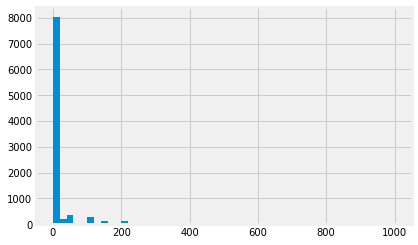

In [19]:
#not sure if I want to bin the fee variable. going to leave it as continuous for now, may edit later.

train.Fee.hist(bins=50);
train.Fee.describe()

#### exploratory analysis

In [20]:
train.head(20)

,Type,Name,Age,Gender,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,VideoAmt,PhotoAmt,Adopted,ColorName
0,1,1,3,0,Small,Short,0,0,0,1,100,0,1,1,Black
1,1,0,1,0,Medium,Medium,0,0,0,1,0,0,2,1,Black
2,0,1,1,0,Medium,Medium,1,1,0,1,0,0,7,1,Brown
3,0,1,4,1,Medium,Short,1,1,0,1,150,0,8,1,Black
4,0,1,1,0,Medium,Short,0,0,0,1,0,0,3,1,Black
5,1,0,3,1,Medium,Short,0,0,0,1,0,0,2,1,Cream
6,1,1,12,0,Medium,Long,0,0,0,1,300,0,3,1,Black
7,1,0,2,1,Medium,Medium,0,0,0,1,0,0,6,1,Gray
8,1,1,12,1,Medium,Medium,0,0,0,1,0,0,2,0,Black
9,0,1,2,0,Medium,Short,0,1,0,1,0,0,7,1,Black


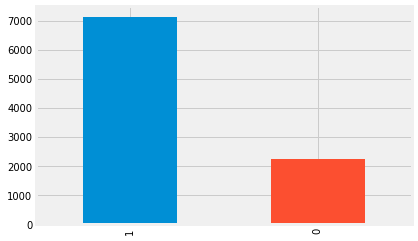

In [21]:
#visualize the target variable

train.Adopted.value_counts().plot(kind='bar'); 
#not super balanced... but is it bad enough to have to manually intervene? i will say no at this point

In [22]:
count_no = len(train[train['Adopted']==0])
count_yes = len(train[train['Adopted']==1])
pct_of_no = count_no /(count_no+count_yes)
print("percentage of animals not adopted is", pct_of_no*100,"%")
pct_of_yes = count_yes/(count_no+count_yes)
print("percentage of animals adopted is", pct_of_yes*100,"%")

percentage of animals not adopted is 23.98165920238857 %
percentage of animals adopted is 76.01834079761143 %


In [23]:
train.groupby('Adopted').mean()
#quick way to view differences across target variable

,Type,Name,Age,Gender,Vaccinated,Dewormed,Sterilized,Health,Fee,VideoAmt,PhotoAmt
Adopted,,,,,,,,,,,
0,0.433526,0.914184,6.081814,0.604713,0.459760,0.588706,0.269898,0.956425,20.907959,0.037350,3.036016
1,0.477486,0.941226,3.905737,0.556039,0.360219,0.585496,0.132557,0.975733,18.994950,0.063122,3.910506


Text(0,0.5,'Proportion of Adoptions')

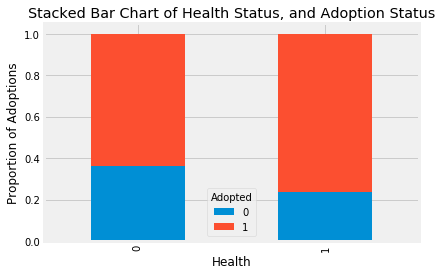

In [25]:
table=pd.crosstab(train.Health,train.Adopted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Health Status, and Adoption Status')
plt.xlabel('Health')
plt.ylabel('Proportion of Adoptions')

Text(0,0.5,'Proportion of Adoptions')

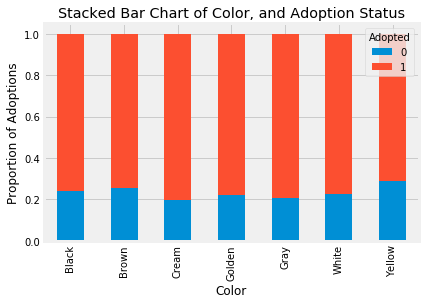

In [26]:
table=pd.crosstab(train.ColorName,train.Adopted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Color, and Adoption Status')
plt.xlabel('Color')
plt.ylabel('Proportion of Adoptions')

Text(0,0.5,'Proportion of Adoptions')

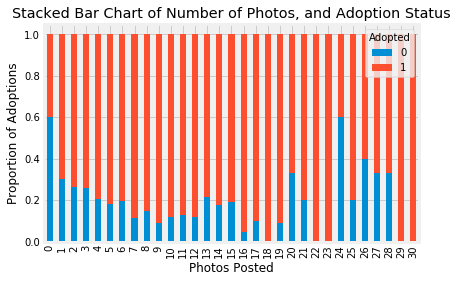

In [27]:
table=pd.crosstab(train.PhotoAmt,train.Adopted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Number of Photos, and Adoption Status')
plt.xlabel('Photos Posted')
plt.ylabel('Proportion of Adoptions')

Text(0,0.5,'Proportion of Adoptions')

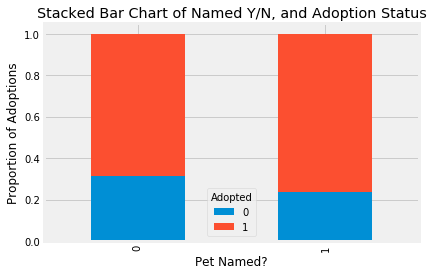

In [37]:
table=pd.crosstab(train.Name,train.Adopted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Named Y/N, and Adoption Status')
plt.xlabel('Pet Named?')
plt.ylabel('Proportion of Adoptions')

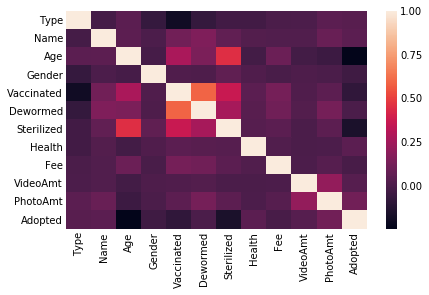

In [28]:
sns.heatmap(train.corr())
#nothing super correlated with adopted

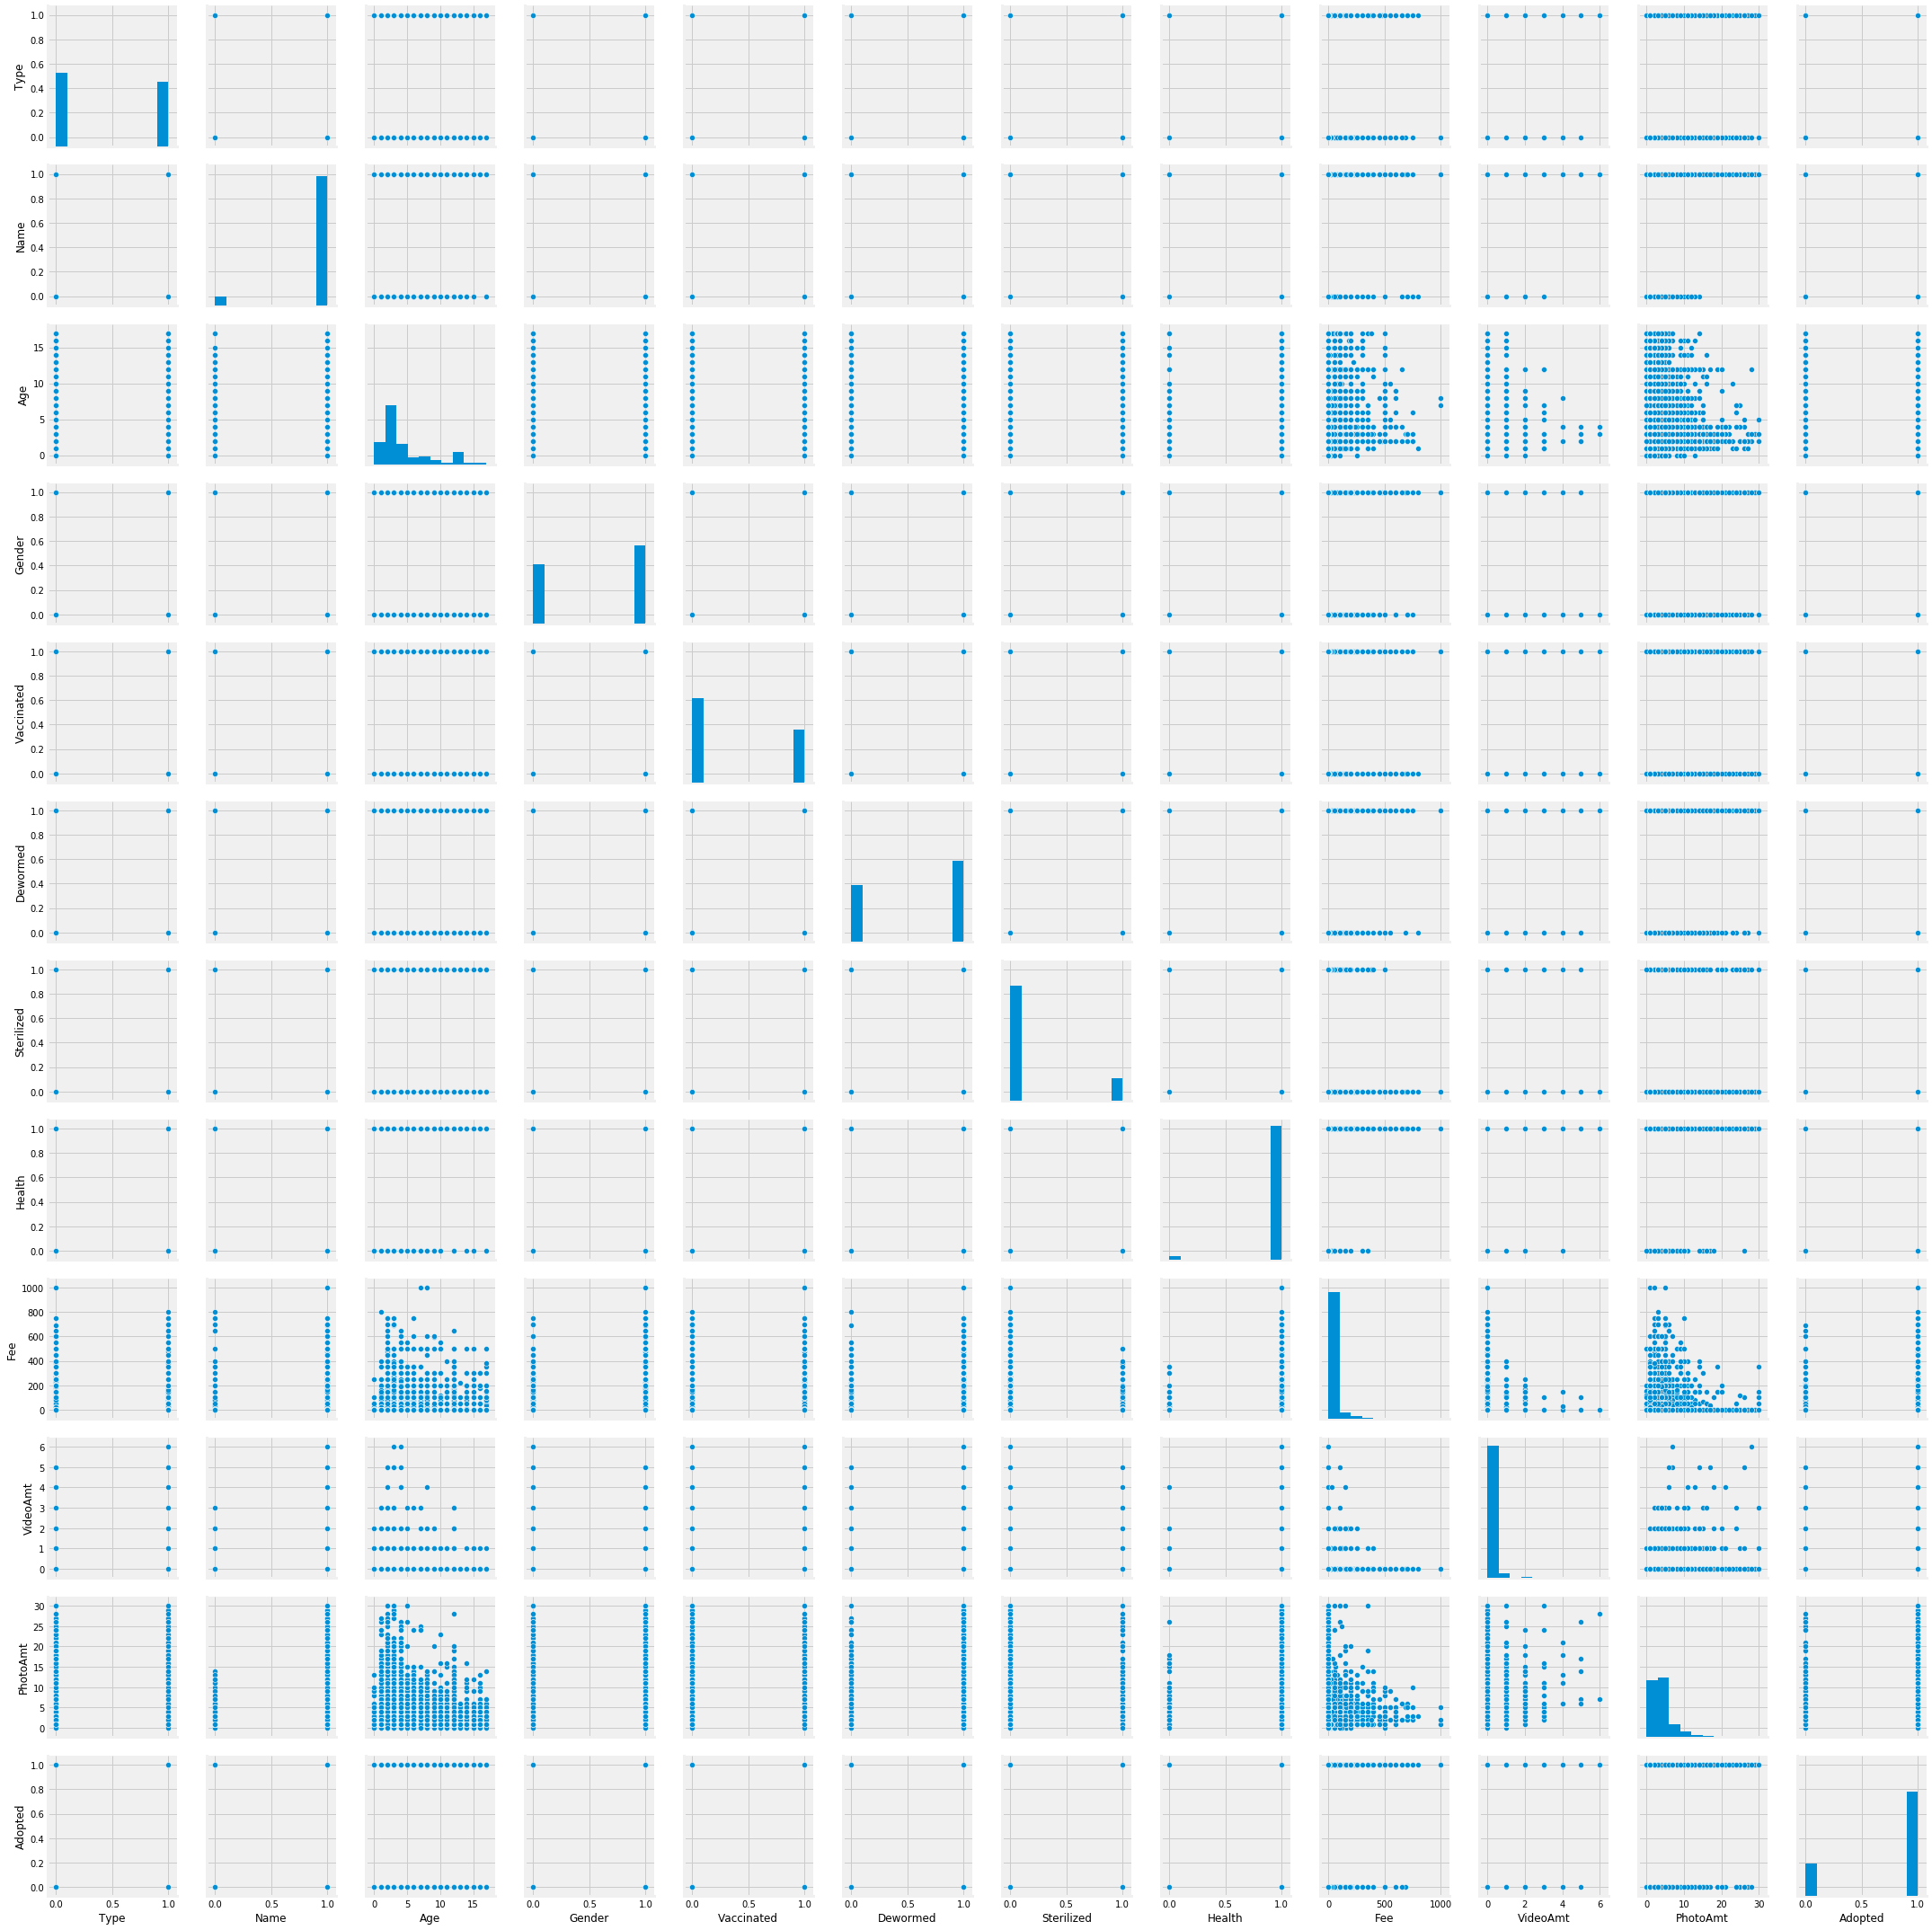

In [29]:
sns.pairplot(train);
#so ugly

#### create dummy variables

In [30]:
#variable types

cat_vars=['MaturitySize', 'FurLength', 'ColorName']
binary_vars= ['Type', 'Gender', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health']
cont_vars= ['Age', 'Fee', 'PhotoAmt', 'VideoAmt']
target = ['Adopted']

In [31]:
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train[var], prefix=var)
    train1=train.join(cat_list)
    train=train1

train_vars=train.columns.values.tolist()
to_keep=[i for i in train_vars if i not in cat_vars]

In [32]:
train_final=train[to_keep]
train_final.columns.values

array(['Type', 'Name', 'Age', 'Gender', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Fee', 'VideoAmt', 'PhotoAmt', 'Adopted',
       'MaturitySize_ExtraLarge', 'MaturitySize_Large',
       'MaturitySize_Medium', 'MaturitySize_Small', 'FurLength_Long',
       'FurLength_Medium', 'FurLength_Short', 'ColorName_Black',
       'ColorName_Brown', 'ColorName_Cream', 'ColorName_Golden',
       'ColorName_Gray', 'ColorName_White', 'ColorName_Yellow'],
      dtype=object)

In [33]:
#final dataset, ready for modeling
train_final.head(10)

,Type,Name,Age,Gender,Vaccinated,Dewormed,Sterilized,Health,Fee,VideoAmt,...,FurLength_Long,FurLength_Medium,FurLength_Short,ColorName_Black,ColorName_Brown,ColorName_Cream,ColorName_Golden,ColorName_Gray,ColorName_White,ColorName_Yellow
0,1,1,3,0,0,0,0,1,100,0,...,0,0,1,1,0,0,0,0,0,0
1,1,0,1,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
2,0,1,1,0,1,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
3,0,1,4,1,1,1,0,1,150,0,...,0,0,1,1,0,0,0,0,0,0
4,0,1,1,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
5,1,0,3,1,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
6,1,1,12,0,0,0,0,1,300,0,...,1,0,0,1,0,0,0,0,0,0
7,1,0,2,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
8,1,1,12,1,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
9,0,1,2,0,0,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0


#### train test split

In [38]:
X = train_final.drop('Adopted', axis=1)
y = train_final.Adopted

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=24)

In [40]:
print(X_train.shape, X_test.shape)

(7502, 25) (1876, 25)
